## Load dataset and train classifier

In [17]:
import time
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from intabs.dataset import InnDataSet
data_name = "compas"
dataset = InnDataSet(data_name)

Using TensorFlow backend.


[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]
[WARNING] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.
 [lazy_loader.py _load]


In [19]:
print(dataset.df.score.values.sum(), dataset.df.score.values.shape)

5028 (6172,)
5028 (6172,)


In [20]:
from intabs.classifier_binary import cross_validation, train_clf, InnModel
d = dataset
epochs = 49
num_h_neurons=None
cross_validation(d, num_h_neurons=None, epochs=epochs, data_name=data_name, linear=True)

Using cuda device
accuracy: 0.8327390599675851+-0.010573423941847702
Using cuda device
accuracy: 0.8327390599675851+-0.010573423941847702


In [21]:
torch_model = train_clf(d.X1_train, d.y1_train, d.X1_test, d.y1_test, num_h_neurons, epochs, data_name, save_clf=False, load_clf=False,linear=True)
model = InnModel(d, torch_model, num_h_neurons)

Evaluations on training data

                  precision    recall  f1-score   support

 bad credit (0)      0.732     0.198     0.312       470
good credit (1)      0.839     0.983     0.905      1998

       accuracy                          0.833      2468
      macro avg      0.786     0.590     0.608      2468
   weighted avg      0.819     0.833     0.792      2468

Evaluations on testing data

                  precision    recall  f1-score   support

 bad credit (0)      0.725     0.248     0.369       117
good credit (1)      0.847     0.978     0.908       500

       accuracy                          0.840       617
      macro avg      0.786     0.613     0.639       617
   weighted avg      0.824     0.840     0.806       617

Evaluations on training data

                  precision    recall  f1-score   support

 bad credit (0)      0.732     0.198     0.312       470
good credit (1)      0.839     0.983     0.905      1998

       accuracy                          0.83

## Experiments 1

First, get $\delta$ value using incremental retraining, and get $\delta$ value using validation set

In [22]:
from intabs.evaluation import get_delta_incremental_training, get_retrained_models_and_validation_set, test_delta_with_val_set
percentages, delta_magnitudes = get_delta_incremental_training(d, model)
inc_delta = delta_magnitudes[5].round(5) # select the delta value corresponding to retraining on 10% size of original data

100%|██████████| 51/51 [00:05<00:00,  9.07it/s]


In [23]:
model.raw_model.to("cpu")
rt_models, val_set, val_y_set =  get_retrained_models_and_validation_set(d, model, num_h_neurons=num_h_neurons, epochs=epochs, linear=True)

100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


In [24]:
val_delta = 0.08
inc_delta = delta_magnitudes[5].round(5)
print(test_delta_with_val_set(d, model, val_delta, val_set, rt_models))

0it [00:00, ?it/s]

Set parameter Username
[INFO] Set parameter Username [intabs.py __init__]
Academic license - for non-commercial use only - expires 2025-02-14
[INFO] Academic license - for non-commercial use only - expires 2025-02-14 [intabs.py __init__]


2918it [00:01, 1587.22it/s]

True



2918it [00:01, 1579.60it/s]

True


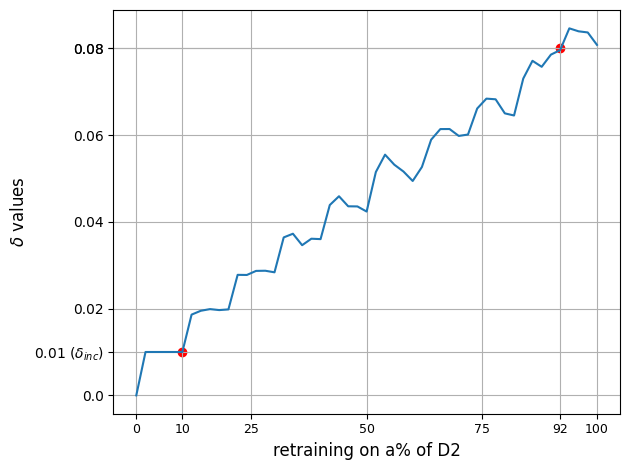

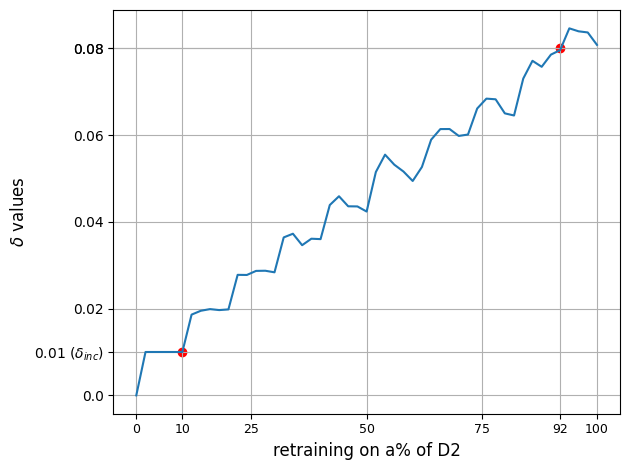

In [25]:
# plot
from intabs.evaluation import plot_deltas
plot_deltas(val_delta, inc_delta, percentages, delta_magnitudes, data_name)

## Experiments 3

Benchmarking CEs

In [26]:
from intabs.evaluation import *
from intabs.methods import run_exps
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
model.raw_model.to("cpu")
rt_models_eval = get_retrained_models_all(d, model, num_h_neurons=num_h_neurons, epochs=epochs, linear=True)

100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


In [27]:
from intabs.methods import run_exps_all_once_lr
model.raw_model.to("cpu")
model = InnModel(d, torch_model, num_h_neurons)
res_1 = run_exps_all_once_lr(d, model, rt_models, rt_models, inc_delta, val_delta, random_seed=100050,
                               run_id=1)


===== running experiments 1/5 =====
===== running our methods 8-12/17, incremental delta =====


5835it [00:03, 1650.59it/s]
20it [00:00, 74.16it/s]


===== running our methods 13-17/17, validation delta =====


5835it [00:03, 1664.73it/s]
20it [00:00, 69.54it/s]


===== running experiments 1/5 =====
===== running our methods 8-12/17, incremental delta =====


5835it [00:03, 1590.79it/s]
20it [00:00, 73.07it/s]


===== running our methods 13-17/17, validation delta =====


5835it [00:03, 1594.93it/s]
20it [00:00, 68.35it/s]


In [28]:
res_2 = run_exps_all_once_lr(d, model, rt_models, rt_models, inc_delta, val_delta, random_seed=7050,
                               run_id=2)

===== running experiments 2/5 =====
===== running our methods 8-12/17, incremental delta =====


5835it [00:03, 1640.67it/s]
20it [00:00, 69.74it/s]


===== running our methods 13-17/17, validation delta =====


5835it [00:03, 1647.46it/s]
20it [00:00, 69.07it/s]


===== running experiments 2/5 =====
===== running our methods 8-12/17, incremental delta =====


5835it [00:03, 1589.03it/s]
20it [00:00, 63.37it/s]


===== running our methods 13-17/17, validation delta =====


5835it [00:03, 1533.26it/s]
20it [00:00, 69.54it/s]


In [29]:
res_3 = run_exps_all_once_lr(d, model, rt_models, rt_models, inc_delta, val_delta, random_seed=3050,
                               run_id=3)

===== running experiments 3/5 =====
===== running our methods 8-12/17, incremental delta =====


5835it [00:03, 1644.70it/s]
20it [00:00, 72.28it/s]


===== running our methods 13-17/17, validation delta =====


5835it [00:03, 1606.74it/s]
20it [00:00, 64.17it/s]


===== running experiments 3/5 =====
===== running our methods 8-12/17, incremental delta =====


5835it [00:03, 1619.74it/s]
20it [00:00, 70.52it/s]


===== running our methods 13-17/17, validation delta =====


5835it [00:03, 1615.19it/s]
20it [00:00, 66.75it/s]


In [30]:
res_4 = run_exps_all_once_lr(d, model, rt_models, rt_models, inc_delta, val_delta, random_seed=3990,
                               run_id=4)

===== running experiments 4/5 =====
===== running our methods 8-12/17, incremental delta =====


5835it [00:03, 1587.60it/s]
20it [00:00, 72.76it/s]


===== running our methods 13-17/17, validation delta =====


5835it [00:03, 1634.27it/s]
20it [00:00, 69.46it/s]


===== running experiments 4/5 =====
===== running our methods 8-12/17, incremental delta =====


5835it [00:03, 1575.22it/s]
20it [00:00, 71.47it/s]


===== running our methods 13-17/17, validation delta =====


5835it [00:04, 1370.53it/s]
20it [00:00, 35.53it/s]


In [31]:
res_5 = run_exps_all_once_lr(d, model, rt_models, rt_models, inc_delta, val_delta, random_seed=6666,
                               run_id=5)

===== running experiments 5/5 =====
===== running our methods 8-12/17, incremental delta =====


5835it [00:03, 1627.81it/s]
20it [00:00, 69.99it/s]


===== running our methods 13-17/17, validation delta =====


5835it [00:03, 1619.12it/s]
20it [00:00, 68.31it/s]


===== running experiments 5/5 =====
===== running our methods 8-12/17, incremental delta =====


5835it [00:04, 1429.69it/s]
20it [00:00, 64.48it/s]


===== running our methods 13-17/17, validation delta =====


5835it [00:03, 1565.17it/s]
20it [00:00, 66.19it/s]


In [32]:
from intabs.methods import run_exps_lr
mean_res, std_res = run_exps_lr(res_1, res_2, res_3, res_4, res_5)

average results
+--------------+------------+--------+-------+-------+--------------+--------------+
| name         |   coverage |   cost |   lof |   vm2 |   vdelta-val |   vdelta-inc |
+==============+============+========+=======+=======+==============+==============+
| nnce         |          1 |  0.034 | 1.318 | 0.736 |         0.01 |         0.49 |
| roar         |          1 |  0.22  | 2.592 | 1     |         1    |         1    |
| rnce         |          1 |  0.035 | 1.3   | 0.861 |         0.01 |         1    |
| rnce-opt     |          1 |  0.033 | 1.344 | 0.781 |         0    |         1    |
| rnce-val     |          1 |  0.045 | 1.219 | 1     |         1    |         1    |
| rnce-opt-val |          1 |  0.043 | 1.296 | 1     |         1    |         1    |
+--------------+------------+--------+-------+-------+--------------+--------------+
std results
+--------------+------------+---------+---------+---------+--------------+--------------+
| name         |   coverage |   